# Random Forest Baseline

Train a RandomForestClassifier on the existing feature set for a tree-based baseline with cross-validation, holdout evaluation, and feature importance visualization.


In [34]:
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.metrics import balanced_accuracy_score


In [35]:

CAT_COLS = [
    'driver_id',
    'constructor_id',
    'circuit_id',
]
NUM_COLS = [
    'grid_position',
    'quali_delta',
    'quali_tm_delta',
    'season_pts_driver',
    'season_pts_team',
    'last_3_avg',
    'is_street_circuit',
    'is_wet',
]
TARGET = 'points_scored'


In [36]:
preprocess = ColumnTransformer(
    [
        ('cat', OneHotEncoder(handle_unknown='ignore'), CAT_COLS),
        ('num', make_pipeline(SimpleImputer(strategy='median'), StandardScaler()), NUM_COLS),
    ],
)

train_df = pd.read_csv("data/grandprix_features_train.csv")
val_df   = pd.read_csv("data/grandprix_features_val.csv") 
test_df  = pd.read_csv("data/grandprix_features_test.csv")

X_train, y_train = train_df[CAT_COLS + NUM_COLS], train_df[TARGET]
X_val,   y_val   = val_df[CAT_COLS + NUM_COLS],   val_df[TARGET]
X_test,  y_test  = test_df[CAT_COLS + NUM_COLS],  test_df[TARGET]

X_train.shape, X_test.shape


((2960, 11), (926, 11))

In [37]:
# Random forest baseline (one-hot + imputer/scaler)
rf = make_pipeline(
    preprocess,
    RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        n_jobs=-1,
        random_state=42,
        class_weight='balanced',
    ),
)

# Fit on training data
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
y_proba = rf.predict_proba(X_val)[:, 1]

print('Precision:', precision_score(y_val, y_pred))
print('Recall:', recall_score(y_val, y_pred))
print('F1 (binary):', f1_score(y_val, y_pred))
print('F1 (macro):', f1_score(y_val, y_pred, average="macro"))
print('Balanced accuracy:', balanced_accuracy_score(y_val, y_pred))

Precision: 0.7789757412398922
Recall: 0.7917808219178082
F1 (binary): 0.7853260869565217
F1 (macro): 0.7864802477793361
Balanced accuracy: 0.7865570776255708


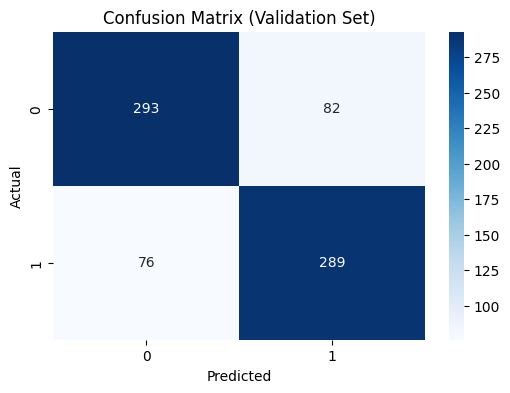

In [38]:
import seaborn as sns

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Validation Set)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()
